# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyxdf
import mne
import pandas as pd
import copy

from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import helpers
from helpers import *
import importlib
import scipy
from scipy import signal
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from operator import itemgetter
from skfeature.function.similarity_based import fisher_score
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [30]:
importlib.reload(helpers)
from helpers import *

# Local functions

In [43]:
def feature_ranking(score,picks,freqs,n_features=None):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    if n_features is None:
        n_features = len(score)

    idx = np.argsort(score, 0)
    sorted_features = idx[::-1][:n_features]
    feature_names = []
    for i in range(len(sorted_features)):
        rank = sorted_features[i]
        sens_id = int(np.floor(rank/len(freqs)))
        freq_id = rank%len(freqs)
        feature_names.append(picks[sens_id]+f'- {str(freqs[freq_id])}')
    return sorted_features,feature_names

# Fisher Score

### Load a subject

In [ ]:
#subject_ID = np.random.randint(1,20)
EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(8,mode='eye_blink')
conditions = list(EEG_dict_corrected.keys())
MIPOST = [x for x in conditions if 'MIpost' in x][0]
MIPRE = [x for x in conditions if 'MIpre' in x][0]
Epoch_dict = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)

In [ ]:
Epoch_dict_,bad_chs_list = reject_bad_chs(Epoch_dict,match=True)

    Using multitaper spectrum estimation with 9 DPSS windows
(60, 12, 19)
(60, 228)
(60,)


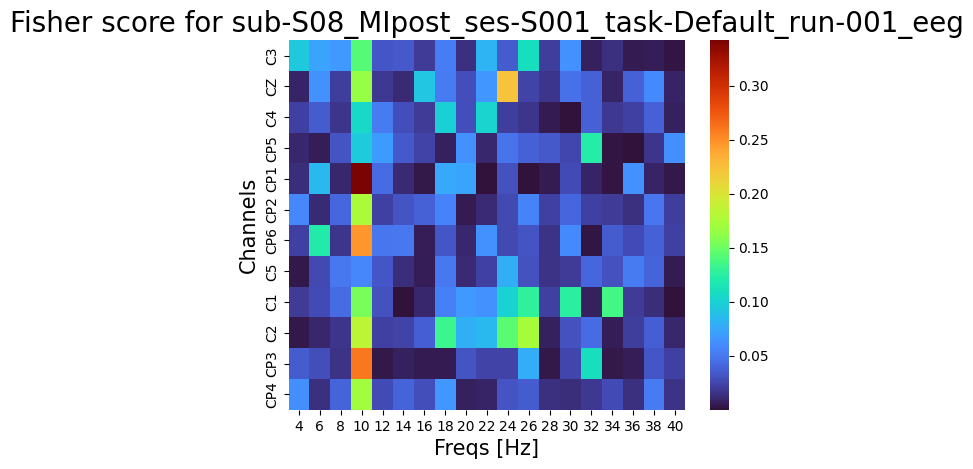

    Using multitaper spectrum estimation with 9 DPSS windows
(49, 12, 19)
(49, 228)
(49,)


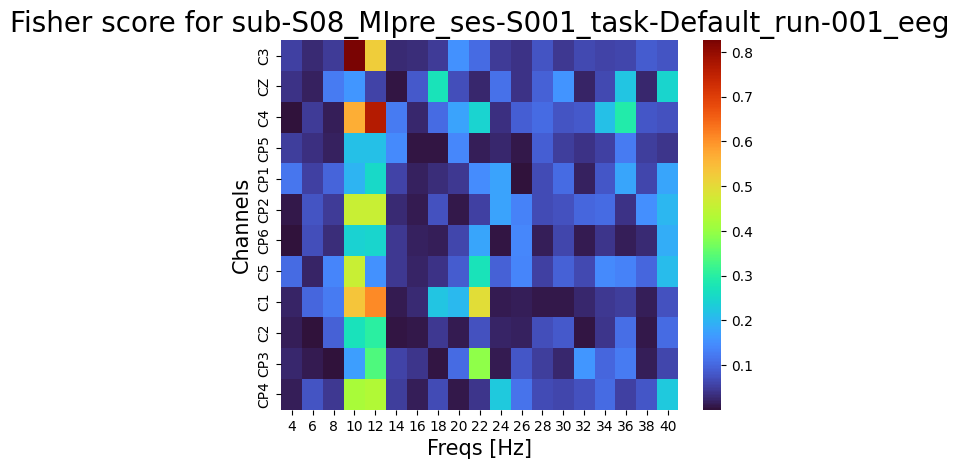

In [32]:
bandpower_dict,f_score_dict,picks,freqs = fisher_analysis(Epoch_dict_,mode='triple')

### First SVM trial 

In [44]:
cond = MIPOST
score = f_score_dict[cond].reshape(f_score_dict[cond].shape[0]*f_score_dict[cond].shape[1])
n_features = 20
ranking,feature_names = feature_ranking(score,picks,freqs,n_features)
n_features = len(ranking)
print(ranking)

KeyboardInterrupt: 

In [19]:
power = bandpower_dict[cond]['power'].copy()
x = power.reshape(power.shape[0],power.shape[1]*power.shape[2])
X = x[:,ranking]
y = bandpower_dict[cond]['labels']

In [20]:
cv_inner = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
cv_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [21]:
history = []
historyT = []
best_models = []
best_params = []
conf_matrix = []
test_set = []
pred_set = []
i = 1
cm_train = []
pointer = 1
for train_index, test_index in cv_outer.split(x, y):                          #3
     print('NestedCV: {} of outer fold {}'.format(pointer, cv_outer.get_n_splits()))
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

     print(x_train.shape)
     print(x_test.shape)
     print(y_train.shape)
     print(y_test.shape)

     # x_train = np.nan_to_num(x_train, nan=-99)
     # x_test = np.nan_to_num(x_test, nan=-99)

     svm_model = svm.SVC(random_state=0)
     model = RandomizedSearchCV(svm_model, param_distributions={'C': np.arange(1,101),'class_weight': ['balanced',{1: 10}],'kernel':['linear', 'rbf']},
                                   scoring='balanced_accuracy', cv=cv_inner, n_jobs=-1)     #4
     model.fit(x_train, y_train)
     
     pred_test = model.predict(x_test)
     pred_training = model.predict(x_train)
     
     
     ba_train = balanced_accuracy_score(y_train, pred_training)
     #     cmT = confusion_matrix(y_train, pred_training, labels=[1,2,3])#5
     ba_test = balanced_accuracy_score(y_test, pred_test)
     test_set.append(y_test)
     cm = confusion_matrix(y_test, pred_test)
     print(cm)
     #     df_cm = pd.DataFrame(cm)
     #     df_cm.to_csv('/kaggle/working' + "/" + "({i})confusion_matrix.csv")
     
     print("""
     # Best set of parameters: {}
     # Best BA             : {:.2f}

     # Training
          # BA: {:.3f}
     # Test
          # BA: {:.3f}
     # """.format(
          model.best_params_,
          model.best_score_,
          ba_train,
          ba_test,
          )
     )
     history.append(ba_test)
     historyT.append(ba_train)
     best_models.append(model.best_estimator_)
     best_params.append(model.best_params_)
     conf_matrix.append(cm)
     #     cm_train.append(cmT)
     pred_set.append(pred_test)
     pointer += 1

print('Overall test performance: {:.2f}'.format(np.mean(history)))

NestedCV: 1 of outer fold 5
(45, 20)
(12, 20)
(45,)
(12,)
[[2 1 1]
 [1 3 0]
 [1 1 2]]

     # Best set of parameters: {'kernel': 'rbf', 'class_weight': {1: 10}, 'C': 79}
     # Best BA             : 0.58

     # Training
          # BA: 0.914
     # Test
          # BA: 0.583
     # 
NestedCV: 2 of outer fold 5
(45, 20)
(12, 20)
(45,)
(12,)
[[2 1 1]
 [1 1 2]
 [3 1 0]]

     # Best set of parameters: {'kernel': 'rbf', 'class_weight': {1: 10}, 'C': 82}
     # Best BA             : 0.49

     # Training
          # BA: 0.956
     # Test
          # BA: 0.250
     # 
NestedCV: 3 of outer fold 5
(46, 20)
(11, 20)
(46,)
(11,)
[[4 0 0]
 [3 0 0]
 [4 0 0]]

     # Best set of parameters: {'kernel': 'linear', 'class_weight': 'balanced', 'C': 97}
     # Best BA             : 0.52

     # Training
          # BA: 0.333
     # Test
          # BA: 0.333
     # 
NestedCV: 4 of outer fold 5
(46, 20)
(11, 20)
(46,)
(11,)
[[2 1 0]
 [1 3 0]
 [0 1 3]]

     # Best set of parameters: {'kernel': 'rbf', 'cl

In [17]:
print(y_test)
print(pred_test)

[3 1 1 2 2 3 3 1 1 2 1 3 2 3 2]
[2 2 1 2 2 3 3 1 1 2 1 3 2 2 2]


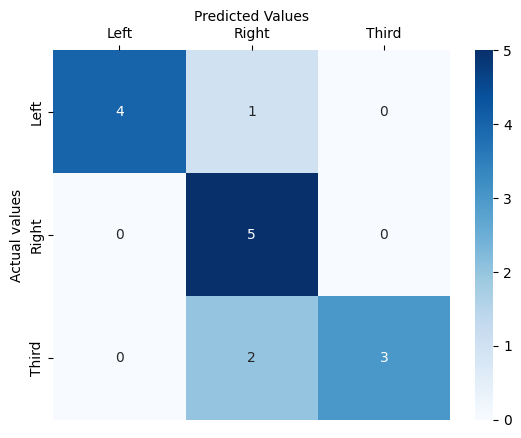

In [21]:
ticklabels = ['Left','Right','Third']
ax = sns.heatmap(conf_matrix[-1], annot=True,cmap='Blues',xticklabels=ticklabels,yticklabels=ticklabels)
ax.set(xlabel="Predicted Values", ylabel="Actual values")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [126]:
# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={1: 1})
wclf.fit(X, y)

SVC(class_weight={1: 1}, kernel='linear')

In [129]:
# Predict the labels of the test data
y_pred = wclf.predict(X)
# Calculate the accuracy of the classifier
conf_matrix = confusion_matrix(y, y_pred)

In [124]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [130]:
conf_matrix

array([[30,  0],
       [19,  0]], dtype=int64)

# Grid search on feature amount + model params

In [22]:
%%capture
cond = MIPOST
mean_perf = []
for k in np.arange(1,20):
    ranking = feature_ranking(f_score_dict[cond].reshape(f_score_dict[cond].shape[0]*f_score_dict[cond].shape[1]),k)
    n_features = len(ranking)
    power = bandpower_dict[cond]['power'].copy()
    x = power.reshape(power.shape[0],power.shape[1]*power.shape[2])
    X = x[:,ranking]
    y = bandpower_dict[cond]['labels']
    cv_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    cv_outer = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
    history = []
    historyT = []
    best_models = []
    best_params = []
    conf_matrix = []
    test_set = []
    pred_set = []
    i = 1
    cm_train = []
    pointer = 1
    for train_index, test_index in cv_outer.split(x, y):                          #3
        print('NestedCV: {} of outer fold {}'.format(pointer, cv_outer.get_n_splits()))
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print(x_train.shape)
        print(x_test.shape)
        print(y_train.shape)
        print(y_test.shape)

        # x_train = np.nan_to_num(x_train, nan=-99)
        # x_test = np.nan_to_num(x_test, nan=-99)

        svm_model = svm.SVC(random_state=0)
        model = RandomizedSearchCV(svm_model, param_distributions={'C': np.arange(1,101),'class_weight': ['balanced',{1: 10}],'kernel':['linear', 'rbf']},
                                    scoring='balanced_accuracy', cv=cv_inner, n_jobs=-1)     #4
        model.fit(x_train, y_train)
        
        pred_test = model.predict(x_test)
        pred_training = model.predict(x_train)
        
        
        ba_train = balanced_accuracy_score(y_train, pred_training)
        #     cmT = confusion_matrix(y_train, pred_training, labels=[1,2,3])#5
        ba_test = balanced_accuracy_score(y_test, pred_test)
        test_set.append(y_test)
        cm = confusion_matrix(y_test, pred_test)
        print(cm)
        #     df_cm = pd.DataFrame(cm)
        #     df_cm.to_csv('/kaggle/working' + "/" + "({i})confusion_matrix.csv")
        
        print("""
        # Best set of parameters: {}
        # Best BA             : {:.2f}

        # Training
            # BA: {:.3f}
        # Test
            # BA: {:.3f}
        # """.format(
            model.best_params_,
            model.best_score_,
            ba_train,
            ba_test,
            )
        )
        history.append(ba_test)
        historyT.append(ba_train)
        best_models.append(model.best_estimator_)
        best_params.append(model.best_params_)
        conf_matrix.append(cm)
        #     cm_train.append(cmT)
        pred_set.append(pred_test)
        pointer += 1

    print('Overall test performance: {:.2f}'.format(np.mean(history)))
    mean_perf.append(np.mean(history))

In [27]:
len(mean_perf)


19

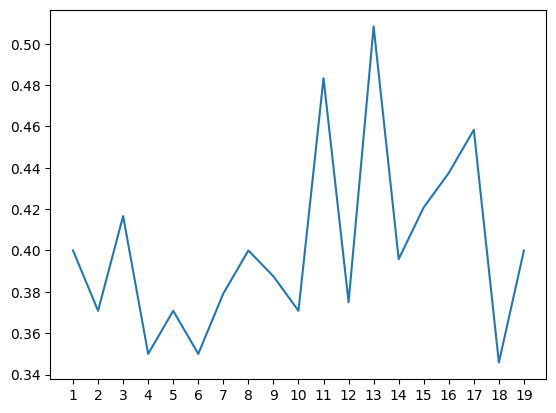

In [29]:
fig = plt.figure()
datax = []
for i in range(len(mean_perf)):
        # In the following assignment statement every value in the datax 
        # list will be set as a string, this solves the floating point issue
        datax += [str(1 + i)]
plt.plot(datax,mean_perf)
plt.show()